# Tutorial 3: Try VGGish Variants

This tutorial shows examples:

- Using VGGish.
- Using VGGish fusion variant proposed in our paper.


### ⚠ Setup before you proceed ⚠

If you have not setup, run the commands in [Setup-commands.txt](../Setup-commands.txt).

---
### 0.1 Making the notebook work better

First, setup autoloading of this notebook. Thanks to https://github.com/ipython/ipython/issues/9732

In [1]:
import IPython

from IPython import get_ipython
ipython = get_ipython()
ipython.magic('reload_ext autoreload')
ipython.magic('autoreload 2')
ipython.magic('matplotlib inline')

### 0.2 Adding path and import modules

We append root folder and EVAR folder to the system `path`.

In [2]:
import sys
sys.path.extend(['..', '../evar'])

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torchaudio

from IPython.display import display, Audio

## 1. Load VGGish


In [4]:
from external.tcvrick_vggish import vggish
from external.tcvrick_vggish.audioset import vggish_input

model = vggish.VGGish()
model.eval()
model.load_state_dict(torch.load('../evar/external/pytorch_vggish.pth'))

<All keys matched successfully>

---
## 2. Load and convert audio clips to spectrograms

We use two animal voices. Thanks to Toro, a Shiba-Inu, and Haru, a black cat.

<table style="background-color:#FFFFFF;">
  <tr>
    <td valign="top"><img src="shibainu-toro.jpg" width="250" /></td>
    <td valign="top"><img src="cat-haru.jpg" width="200" /></td>
  </tr>
  <tr>
    <td style="text-align: center;">Toro</td>
    <td style="text-align: center;">Haru</td>
  </tr>
 </table>
 
 ### 2.1 Load audios

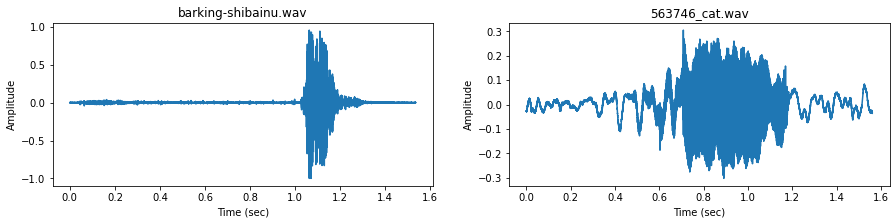

In [5]:
files = ['barking-shibainu.wav', '563746_cat.wav']

def load_sample_mono(file_name, display=True, subplot_idx=None):
    # loads audio in the shape of [channels, samples].
    wav, sr = torchaudio.load(file_name)
    # averages left and right channels into a single monoaural wave data.
    wav = wav.mean(0)

    if display:
        if subplot_idx:
            plt.subplot(subplot_idx)
        plt.plot(np.linspace(0.0, len(wav)/sr, len(wav)), wav)
        plt.xlabel('Time (sec)'); plt.ylabel('Amplitude');
        plt.title(file_name)
    return wav, sr

plt.figure(figsize=(15, 3))
wavs = []
wav, sr = load_sample_mono(files[0], subplot_idx=121)
assert sr == 44100, 'Make sure your audio is a 44.1kHz audio.'
wavs.append(wav)
wav, sr = load_sample_mono(files[1], subplot_idx=122)
assert sr == 44100, 'Make sure your audio is a 44.1kHz audio.'
wavs.append(wav)

### 2.2 Resample to 16kHz, the default sampling rate of VGGish

In [6]:
print('before', wavs[0].shape)
wavs = [torchaudio.functional.resample(wav, sr, vggish_input.vggish_params.SAMPLE_RATE)
    for wav in wavs]
print('after', wavs[0].shape)

before torch.Size([67773])
after torch.Size([24589])


In [7]:
def append_zeros(wav, sr):
    padded_length = int(sr * np.ceil(len(wav) / sr))
    wav = np.pad(wav, ((0, padded_length - len(wav))))
    return wav

print('before', wavs[0].shape)
wavs = [append_zeros(wav, vggish_input.vggish_params.SAMPLE_RATE) for wav in wavs]
print('after', wavs[0].shape)

before torch.Size([24589])
after (32000,)


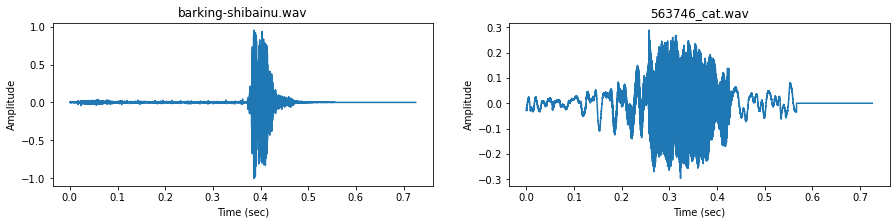

In [8]:
plt.figure(figsize=(15, 3))
for i, wav in enumerate(wavs):
    plt.subplot(121 + i)
    plt.plot(np.linspace(0.0, len(wav)/sr, len(wav)), wav)
    plt.xlabel('Time (sec)'); plt.ylabel('Amplitude');
    plt.title(files[i])

### 2.3 Convert to spectrogram

VGGish (PyTorch implementation) has its own function to convert, `vggish_input.waveform_to_examples()`.

The shape `[2, 2, 96, 64]` means [Batch, Sub-sample, Time frame, Frequency bin].

VGGish accepts 1s input only, which is the shape of [96, 64]. The converter function splits variable-length audio into 1s sub-samples before converting.

In [9]:
X = [vggish_input.waveform_to_examples(wav, vggish_input.vggish_params.SAMPLE_RATE) for wav in wavs]
X = torch.tensor(np.array(X)).float() # ex.) [256, 7, 96, 64] if fsd50k. [B,Frame,T,F]
X.shape

torch.Size([2, 2, 96, 64])

barking-shibainu.wav


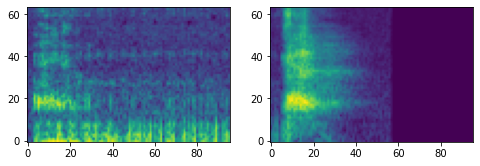

563746_cat.wav


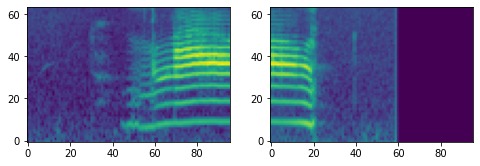

In [10]:
for i, x in enumerate(X):
    plt.figure(figsize=(8, 3))
    print(files[i])
    for j, x_ in enumerate(x):
        plt.subplot(121 + j)
        plt.imshow(x_.T, origin='lower')
    plt.show()

## 3. Encode audios

As VGGish accepts 1s audio each, we will get multiple 1s encoded feature representations.

Note that VGGish still accepts batch samples.

In [11]:
y_dog = model(X[0].unsqueeze(1)) # The first batch sample is dog's.
y_cat = model(X[1].unsqueeze(1))
y_dog.shape, y_cat.shape

(torch.Size([2, 128]), torch.Size([2, 128]))

barking-shibainu.wav


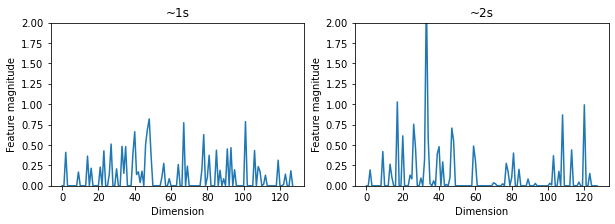

563746_cat.wav


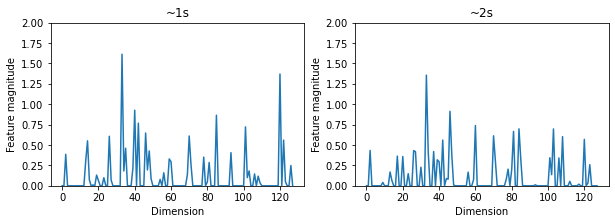

In [12]:
def plot_features(features, ylim=[0, 2.0]):
    for i, y in enumerate(features):
        plt.figure(figsize=(10, 3))
        print(files[i])
        for j, y_ in enumerate(y.detach().numpy()):
            plt.subplot(121 + j)
            plt.plot(y_)
            plt.ylim(ylim)
            plt.title(f'~{j + 1}s')
            plt.ylabel('Feature magnitude'); plt.xlabel('Dimension')
        plt.show()

plot_features([y_dog, y_cat])

#### We encoded audio into feature representations

As you can see, we get 128-d features for each 1s of the samples with VGGish. We typically average over time for getting clip-level features.

## 4. Using VGGish fusion model

In [13]:
from gp_vggish import GeneralPurposeVGGish

model = GeneralPurposeVGGish()
model.eval()
model.load_state_dict(torch.load('../evar/external/pytorch_vggish.pth'))

<All keys matched successfully>

In [14]:
y_dog = model(X[0].unsqueeze(1)) # The first batch sample is dog's.
y_cat = model(X[1].unsqueeze(1))
y_dog.shape, y_cat.shape

(torch.Size([2, 8192]), torch.Size([2, 8192]))

barking-shibainu.wav


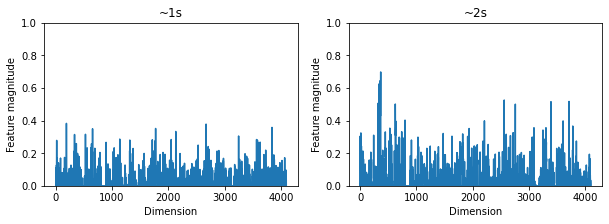

563746_cat.wav


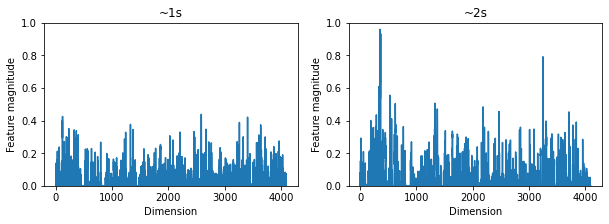

In [19]:
plot_features([y_dog, y_cat], ylim=[0, 1.0])

### 4.1 Convert to a specific layer feature

torch.Size([2, 4096]) torch.Size([2, 4096])
barking-shibainu.wav


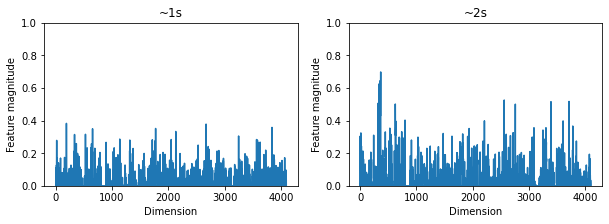

563746_cat.wav


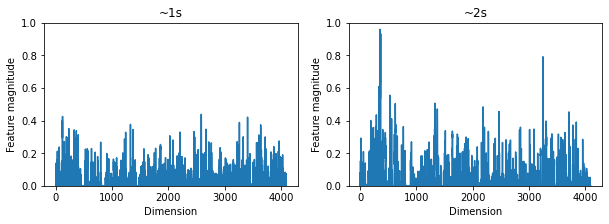

In [21]:
layers = [9]
y_dog = model(X[0].unsqueeze(1), layers=layers) # The first batch sample is dog's.
y_cat = model(X[1].unsqueeze(1), layers=layers)
print(y_dog.shape, y_cat.shape)
plot_features([y_dog, y_cat], ylim=[0, 1.0])

torch.Size([2, 4096]) torch.Size([2, 4096])
barking-shibainu.wav


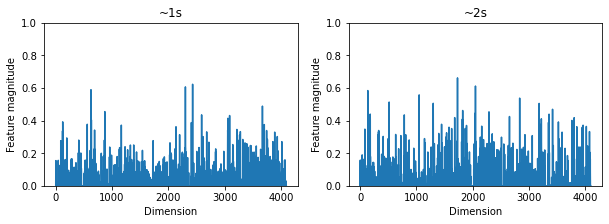

563746_cat.wav


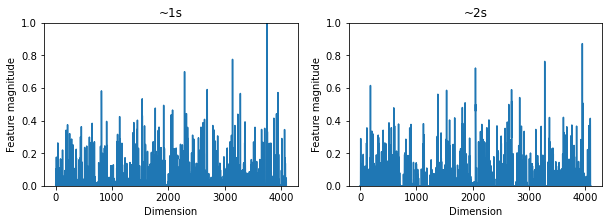

In [22]:
layers = [14]
y_dog = model(X[0].unsqueeze(1), layers=layers) # The first batch sample is dog's.
y_cat = model(X[1].unsqueeze(1), layers=layers)
print(y_dog.shape, y_cat.shape)
plot_features([y_dog, y_cat], ylim=[0, 1.0])

### 4.2 You can even combine more features

Available layer numbers $\in [1, 4, 7, 9, 12, 14, 17, 19, 21]$

torch.Size([2, 16384]) torch.Size([2, 16384])
barking-shibainu.wav


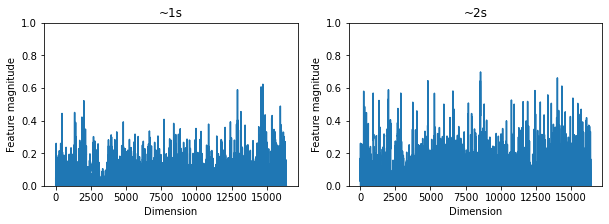

563746_cat.wav


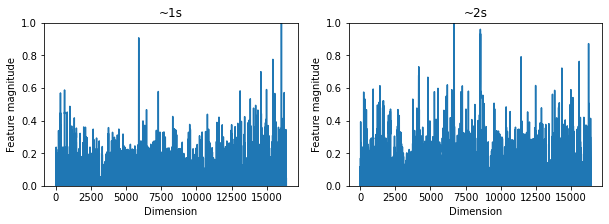

In [32]:
layers = [4, 7, 9, 14]
y_dog = model(X[0].unsqueeze(1), layers=layers) # The first batch sample is dog's.
y_cat = model(X[1].unsqueeze(1), layers=layers)
print(y_dog.shape, y_cat.shape)
plot_features([y_dog, y_cat], ylim=[0, 1.0])